In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from tqdm.auto import tqdm
import pickle
import os
from run_functions import *
from agent_functions import *
from plot_functions import *
from routing_networks import *
from recommenders import *
import math
import nolds
import sklearn

game properties:
- number of players
    - fixed
    - variable
- number of actions
    - fixed
    - variable
- state space
    - size
- reward 
    - max
    - min

In [4]:
def duopoly(a1, a2, n_actions=6):
    
    p1 = a1/n_actions
    p2 = a2/n_actions
    
    if p1 < p2:
        r1 = (1 - p1)*p1
        r2 = 0
    if p1 == p2:
        r1 = 0.5*(1 - p1)
        r2 = r1
    if p1 > p2:
        r1 = 0
        r2 = (1 - p2)*p2
    
    R = np.array([r1, r2])
    S = np.array([a2, a1])
    
    return R, S

In [5]:
def prisoners_dilemma(a1, a2, r, s):
    if a1 == 0 and a2 == 0:
        r1 = r
        r2 = r
    elif a1 == 0 and a2 == 1:
        r1 = -s
        r2 = 1
    elif a1 == 1 and a2 == 0:
        r1 = 1
        r2 = -s
    elif a1 == 1 and a2 == 1:
        r1 = 0
        r2 = 0
    
    state = a1 + a2
    
    R = np.array([r1, r2])
    S = np.array([state, state])
    
    return R, S

In [39]:
N_AGENTS = 2
N_STATES = 4
N_ACTIONS = 2
N_ITER = 10000

EPSILON = 0.05
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])

In [40]:
%%time
def run(EPSILON):
    # Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)
    Q = np.random.random((N_AGENTS, N_STATES, N_ACTIONS)) - 0.5

    ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = EPSILON
    EPS_END = EPSILON
    EPS_DECAY = N_ITER/8

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)
    action1 = A[0]
    action2 = A[1]

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)
        
        duopoly=False
        if duopoly == True:
            if t%2 == 0:
                action1 = A[0]
            else:
                action2 = A[1]
        else:
            action1 = A[0]
            action2 = A[1]
        
        if duopoly:
            R, S = duopoly(a1=action1, a2=action2, n_actions=N_ACTIONS)
        else:
            R, S = prisoners_dilemma(a1=action1, a2=action2, r = 0.5, s=0.5)

        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

        ### SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                #"groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                "nA": np.bincount(A, minlength=3),
                # "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
                }
    return M, elist

CPU times: user 9 µs, sys: 31 µs, total: 40 µs
Wall time: 53.9 µs


Text(0, 0.5, 'welfare')

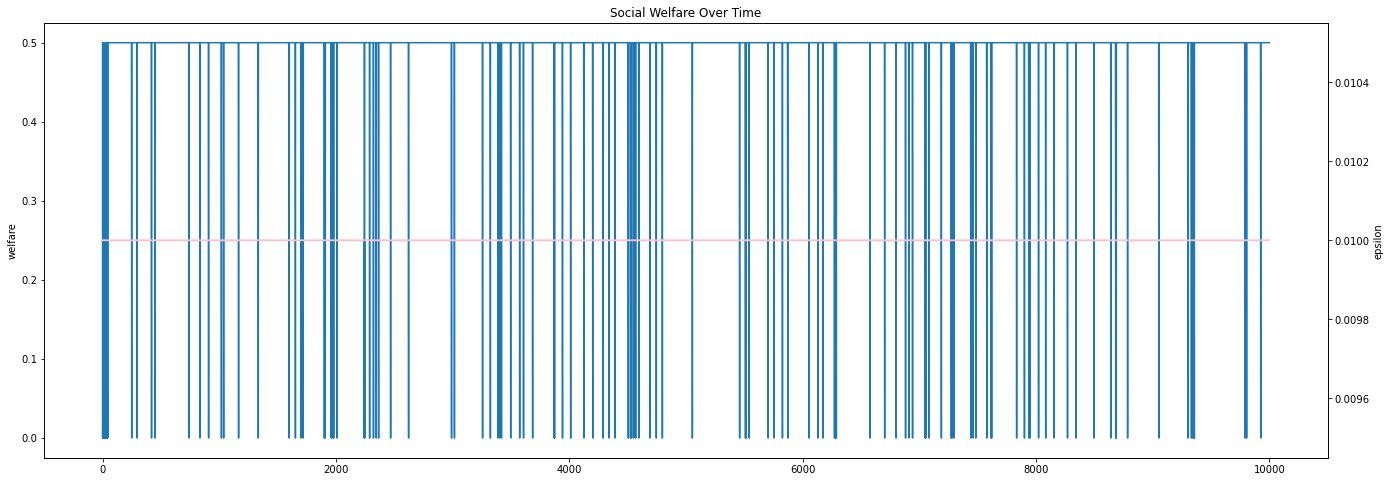

In [41]:
M, elist = run(0.01)
fig, ax = plt.subplots(figsize=(23,8))
ax.plot([M[t]["R"].mean() for t in M.keys()])
ax2=ax.twinx()
ax2.plot(elist, color='pink')
ax2.set_ylabel("epsilon")
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
ax.set_ylabel("welfare")
#ax.set_ylim((0,0.5))

In [152]:
[M[t]["R"].mean() for t in M.keys()]

[0.0,
 0.25,
 0.25,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.25,
 0.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.0,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.25,
 0.0,
 0.25,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.25,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.25,
 0.25,
 0.25,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.25,
 0.25,
 0.25,
 0.0,
 0.5,
 0.25,
 0.0,
 0.5,
 0.0,
 0.

In [42]:
results_dict = {}

for epsilon in tqdm(np.linspace(0, 1, 101)):
    repetitions = {}
    for i in range(10):
        M, elist = run(epsilon)
        repetitions[i] = np.array([M[t]["R"].mean() for t in M.keys()])
    results_dict[epsilon] = repetitions

  0%|          | 0/101 [00:00<?, ?it/s]

In [43]:
path = "dynamics_results"
name = "prisoners_q-learning_epsilon-sweep_alpha01"

In [36]:
with open(f"{path}/{name}", "rb") as file:
    results_dict = pickle.load(file)

In [44]:
epsilons = np.linspace(0, 1, 101)
ind1, ind2 = -5000, -1
means = np.array([np.array([x[ind1:ind2].mean() for x in dictionary.values()]).mean() for dictionary in results_dict.values()])
q25 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 25) for dictionary in results_dict.values()])
q75 = np.array([np.percentile(np.array([x[ind1:ind2].mean() for x in dictionary.values()]), 75) for dictionary in results_dict.values()])

In [19]:
lyapunov = np.array([np.array([nolds.lyap_r(x[ind1:ind2]) for x in dictionary.values()]).mean() for dictionary in results_dict.values()])

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nold

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.p

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.p

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.p

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Run

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.p

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 274
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Run

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: Un

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-package

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: Un

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning:

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: Runti

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 1249
  warnings.warn(msg.format(min_tsep), RuntimeWarning)

KeyboardInterrupt



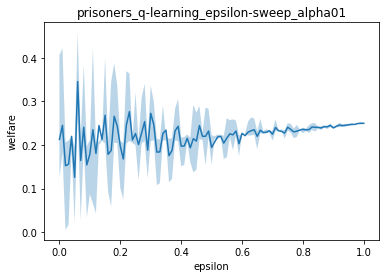

In [45]:
plt.plot(epsilons, means)
plt.fill_between(epsilons, q25, q75, alpha=0.3)
plt.title(name)
plt.ylabel("welfare")
plt.xlabel("epsilon")
plt.savefig(f"{path}/welfare_{name}.png")

In [ ]:
plt.plot(epsilons, lyapunov)
# plt.fill_between(epsilons, q25, q75, alpha=0.3)

In [187]:
with open(f"dynamics_results/{name}", "wb") as file:
    pickle.dump(results_dict, file)